In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
!pip install catboost
import pandas as pd
import numpy as np
import os
import seaborn as sns 
from scipy import stats
from scipy.stats import norm,skew
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import xgboost as xgb
import catboost as catb
import operator
import time
import ast
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")


     |████████████████████████████████| 64.4MB 61kB/s 


In [0]:
import pandas as pd
#https://drive.google.com/open?id=1bOQiIBne8aPCg6hLKeiHLTklS2mnWdII
#https://drive.google.com/open?id=1Gb6aE1lJn3jukR0_DKfhwjj-AnP9c6XS
tr1_id = '1bOQiIBne8aPCg6hLKeiHLTklS2mnWdII'
tr2_id = '1Gb6aE1lJn3jukR0_DKfhwjj-AnP9c6XS'

down1 = drive.CreateFile({'id':tr1_id})
down2 = drive.CreateFile({'id':tr2_id})

down1.GetContentFile('train.csv')
down2.GetContentFile('test.csv')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

train.head()

(3000, 23)
(4398, 22)


id  ...   revenue
0   1  ...  12314651
1   2  ...  95149435
2   3  ...  13092000
3   4  ...  16000000
4   5  ...   3923970

[5 rows x 23 columns]

In [0]:
m_train, n1 = train.shape
m_test, n2 = test.shape
print("{} training samples".format(m_train))
print("{} test samples".format(m_test))
print("{} features for train samples".format(n1))
print("{} features for test samples".format(n2))

3000 training samples
4398 test samples
23 features for train samples
22 features for test samples


In [0]:
# Delete unused columns
train.drop(columns=['imdb_id', 'poster_path'], inplace=True)
test.drop(columns=['imdb_id', 'poster_path'], inplace=True)

# Cast budget and revenue to float
train.budget = train.budget.astype(float)
train.revenue = train.revenue.astype(float)
test.budget = test.budget.astype(float)

In [0]:
belongs_df = train[['belongs_to_collection', 'revenue']]
belongs_df['belongs_to_collection_bool'] = True
belongs_df.belongs_to_collection_bool[train.belongs_to_collection.isnull()] = False
belongs_df.head()
features = belongs_df['belongs_to_collection_bool']
features.value_counts()

False    2396
True      604
Name: belongs_to_collection_bool, dtype: int64

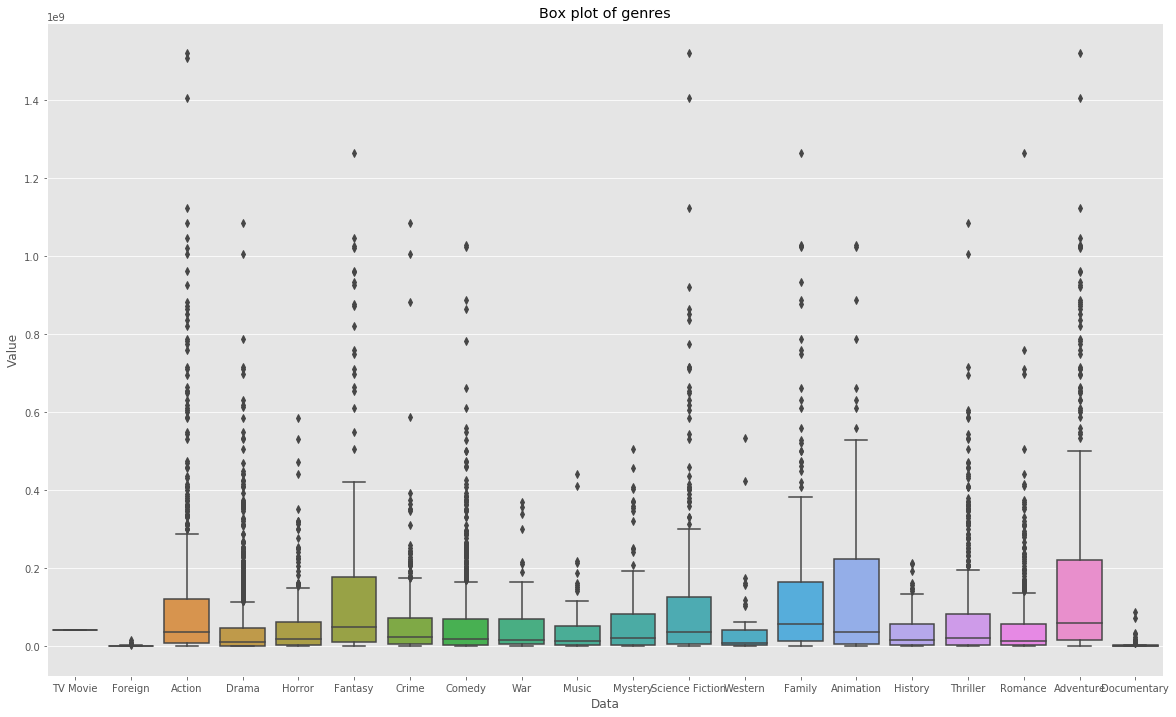

In [0]:
# "genres": Clean, EDA and create bools > True if belongs to a specific genre, False if not
genres_df = train[['genres', 'revenue']]
genres_df['genres_test'] = genres_df['genres']
genres_df.head()
genres_df.genres_test = genres_df.genres_test.str.strip('[]')
genres_df.genres_test[genres_df.genres_test.isnull()] = ''
genres_list = pd.Series(list(set(", ".join(genres_df.genres_test.unique().tolist()).split('}, ')))).str.split("'name': '").str[1].str.split("'").str[0].tolist()
#genres_list
for i, genre in enumerate(genres_list):
    genres_df[genre] = np.nan
    genres_df[genre][genres_df.genres_test.str.contains(genre)] = genres_df.revenue[genres_df.genres_test.str.contains(genre)]
genres_df.drop(columns=['revenue', 'genres', 'genres_test'], inplace=True)
genres_df.head()
# genres_boxplot = genres_df.boxplot(figsize=(15, 10), rot=90)
plt.figure(figsize=(20,12))
sns.boxplot(data=genres_df)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Box plot of genres')
plt.show()



In [0]:
train.dropna().shape

(203, 21)

In [0]:
##Train Revenue and Budget
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 3000000        # All at Once
train.loc[train['id'] == 1542,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture

In [0]:
# Test Budget
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee


In [0]:
# TRAIN 

train.runtime[train.id == 391] = 86 #Il peor natagle de la meva vida
train.runtime[train.id == 592] = 90 #А поутру они проснулись
train.runtime[train.id == 925] = 95 #¿Quién mató a Bambi?
train.runtime[train.id == 978] = 93 #La peggior settimana della mia vita
train.runtime[train.id == 1256] = 92 #Cipolla Colt
train.runtime[train.id == 1542] = 93 #Все и сразу
train.runtime[train.id == 1875] = 86 #Vermist
train.runtime[train.id == 2151] = 108 #Mechenosets
train.runtime[train.id == 2499] = 108 #Na Igre 2. Novyy Uroven
train.runtime[train.id == 2646] = 98 #同桌的妳
train.runtime[train.id == 2786] = 111 #Revelation
train.runtime[train.id == 2866] = 96 #Tutto tutto niente niente

# TEST
test.runtime[test.id == 4074] = 103 #Shikshanachya Aaicha Gho
test.runtime[test.id == 4222] = 93 #Street Knight
test.runtime[test.id == 4431] = 100 #Плюс один
test.runtime[test.id == 5520] = 86 #Glukhar v kino
test.runtime[test.id == 5845] = 83 #Frau Müller muss weg!
test.runtime[test.id == 5849] = 140 #Shabd
test.runtime[test.id == 6210] = 104 #Le dernier souffle
test.runtime[test.id == 6804] = 145 #Chaahat Ek Nasha..
test.runtime[test.id == 7321] = 87 #El truco del manco

In [0]:
power_six = train.id[train.budget > 1000][train.revenue < 100]
for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

train.loc[train['id'] == 1282]

id  ...     revenue
1281  1282  ...  46000000.0

[1 rows x 21 columns]

In [0]:
##Log transformation of Popularity, Budget and Revenue
train['budget'] = np.log1p(train['budget'])
test['budget'] = np.log1p(test['budget'])

train['popularity'] = np.log1p(train['popularity'])
test['popularity'] = np.log1p(test['popularity'])


In [0]:
train.loc[train["cast"].notnull(),"cast"]=train.loc[train["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
train.loc[train["crew"].notnull(),"crew"]=train.loc[train["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))
test.loc[test["cast"].notnull(),"cast"]=test.loc[test["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
test.loc[test["crew"].notnull(),"crew"]=test.loc[test["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))

train.loc[train["cast"].notnull(),"cast"]=train.loc[train["cast"].notnull(),"cast"]\
.apply(lambda x : [y["name"] for y in x if y["order"]<6])
test.loc[test["cast"].notnull(),"cast"]=test.loc[test["cast"].notnull(),"cast"]\
.apply(lambda x : [y["name"] for y in x if y["order"]<6])

train.loc[train["cast"].notnull(),"cast"][0]

['Rob Corddry',
 'Craig Robinson',
 'Clark Duke',
 'Adam Scott',
 'Chevy Chase',
 'Gillian Jacobs']

In [0]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue'],
      dtype='object')

In [0]:
def get_DirProdExP(df):
    df["Director"]=[[] for i in range(df.shape[0])]
    df["Producer"]=[[] for i in range(df.shape[0])]
    df["Executive Producer"]=[[] for i in range(df.shape[0])]

    df["Director"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Director"])

    df["Producer"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Producer"])

    df["Executive Producer"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Executive Producer"])
    
    return df

train = get_DirProdExP(train)
test = get_DirProdExP(test)

train.head(3)


id  ...                                 Executive Producer
0   1  ...              [Rob Corddry, Ben Ormand, Matt Moore]
1   2  ...                                [Ellen H. Schwartz]
2   3  ...  [Jason Reitman, Gary Michael Walters, Jeanette...

[3 rows x 24 columns]

In [0]:
train.describe()

id       budget    popularity      runtime       revenue
count  3000.000000  3000.000000  3.000000e+03  2998.000000  3.000000e+03
mean   1500.500000    11.985069  1.975396e+00   108.242161  6.672403e+07
std     866.169729     7.394925  7.416869e-01    21.020877  1.374992e+08
min       1.000000     0.000000  9.999995e-07    11.000000  1.000000e+00
25%     750.750000     0.000000  1.613042e+00    94.000000  2.447642e+06
50%    1500.500000    15.894952  2.125233e+00   104.000000  1.692863e+07
75%    2250.250000    17.216708  2.475780e+00   118.000000  6.877599e+07
max    3000.000000    19.755682  5.688117e+00   338.000000  1.519558e+09

In [0]:
train['spoken_languages'] = train['spoken_languages'].apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test['spoken_languages'] = test['spoken_languages'].apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))

train.head().spoken_languages

#Now we can create 2 additional features: the number of spoken languages, and wheter the english belongs to them.
train['nb_spoken_languages'] = train.spoken_languages.apply(len)
test['nb_spoken_languages'] = test.spoken_languages.apply(len)

#train['english_spoken'] = train.spoken_languages.apply(lambda x: 'en' in x)
#test['english_spoken'] = test.spoken_languages.apply(lambda x: 'en' in x)

train['english_spoken'] = train.spoken_languages.apply(lambda x: 1 if 'en' in x else 0)
test['english_spoken'] = test.spoken_languages.apply(lambda x: 1 if 'en' in x else 0)

all_languages = pd.concat([train.original_language, test.original_language], axis=0).value_counts()
all_languages[all_languages > 10]
# Here are the main languages
main_languages = list(all_languages[all_languages>20].index)
# Let's categorize them, and add a 'other' catergorie
dict_language = dict(zip(main_languages, range(1, len(main_languages)+1)))
dict_language['other'] = 0
#keep only the languages that are on main_languages
train.original_language = train.original_language.apply(lambda x: x if x in main_languages else 'other')
test.original_language = test.original_language.apply(lambda x: x if x in main_languages else 'other')

#put languages to numeric according to the indexes of the dictionary
train['language'] = train.original_language.apply(lambda x: dict_language[x])
test['language'] = test.original_language.apply(lambda x: dict_language[x])

train.head(3)

id  ... language
0   1  ...        1
1   2  ...        1
2   3  ...        1

[3 rows x 27 columns]

In [0]:
train.genres = train.genres.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))
test.genres = test.genres.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))

train.genres.head()


0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: genres, dtype: object

In [0]:
train.genres.head(3)

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
Name: genres, dtype: object

In [0]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue', 'Director', 'Producer', 'Executive Producer',
       'nb_spoken_languages', 'english_spoken', 'language'],
      dtype='object')

In [0]:
train.genres.head()

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: genres, dtype: object

In [0]:
train.Keywords = train.Keywords.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))
test.Keywords = test.Keywords.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))

train['nb_keywords'] = train.Keywords.apply(len)
test['nb_keywords'] = test.Keywords.apply(len)

train.nb_keywords.head()

0     4
1     4
2    12
3     7
4     0
Name: nb_keywords, dtype: int64

In [0]:
train.production_companies = train.production_companies.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test.production_companies = test.production_companies.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))


In [0]:
train['nb_production_companies'] = train.production_companies.apply(len)
test['nb_production_companies'] = test.production_companies.apply(len)


In [0]:
train.production_countries = train.production_countries.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test.production_countries = test.production_countries.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))


In [0]:
test.loc[test.release_date.isna(), 'release_date'] = '05/01/00'

#Train
train['release_date'] = pd.to_datetime(train['release_date'], format='%m/%d/%y')
train['Year'] = train.release_date.dt.year
train['Month'] = train.release_date.dt.month
train['Day'] = train.release_date.dt.day
train['dayofweek'] = train.release_date.dt.dayofweek 
train['quarter'] = train.release_date.dt.quarter   
#Test
test['release_date'] = pd.to_datetime(test['release_date'], format='%m/%d/%y')
test['Year'] = test.release_date.dt.year
test['Month'] = test.release_date.dt.month
test['Day'] = test.release_date.dt.day
test['dayofweek'] = test.release_date.dt.dayofweek 
test['quarter'] = test.release_date.dt.quarter  

#Dummy Month
dummies = pd.get_dummies(train['Month'] ,drop_first=True).rename(columns=lambda x: 'Month' + str(x))
dummies2 = pd.get_dummies(test['Month'] ,drop_first=True).rename(columns=lambda x: 'Month' + str(int(x)))
train = pd.concat([train, dummies], axis=1)
test = pd.concat([test, dummies2], axis = 1)

#Dummy DayofWeek
ddow = pd.get_dummies(train['dayofweek'] ,drop_first=True).rename(columns=lambda x: 'dayofweek' + str(x))
ddow2 = pd.get_dummies(test['dayofweek'] ,drop_first=True).rename(columns=lambda x: 'dayofweek' + str(int(x)))
train = pd.concat([train, ddow], axis=1)
test = pd.concat([test, ddow2], axis = 1)

print ('Train: ' + str(max(train.Year)) + ' Test: ' + str(max(test.Year)))

train[train.Year==2068].release_date.head()

#Train
train.loc[train['Year'] > 2018, 'Year'] = train.loc[train['Year'] > 2018, 'Year'].apply(lambda x: x - 100)
#Test
test.loc[test['Year'] > 2018, 'Year'] = test.loc[test['Year'] > 2018, 'Year'].apply(lambda x: x - 100)

test.Year.describe()

Train: 2068 Test: 2068


count    4398.000000
mean     1999.675307
std        15.286695
min      1922.000000
25%      1992.000000
50%      2004.000000
75%      2011.000000
max      2018.000000
Name: Year, dtype: float64

In [0]:
def lazzy_feat(df):
    
    df['Ratiobudgetbypopularity'] = df['budget']/df['popularity']
    df['RatiopopularitybyYear'] = df['popularity']/df['Year']
    df['RatoioruntimebyYear'] = df['runtime']/df['Year']
    
    
    df['budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['budget_Year_ratio'] = df['budget']/df['Year']
    
    return df

train = lazzy_feat(train)
test = lazzy_feat(test)

train['has_homepage'] = np.where(train['homepage'].isna(), 0, 1)
train ['has_collection'] = np.where(train['belongs_to_collection'].isna(), 0, 1)
train['has_homepage'] = np.where(train['homepage'].isna(), 0, 1)
train ['has_collection'] = np.where(train['belongs_to_collection'].isna(), 0, 1)

test['has_homepage'] = np.where(test['homepage'].isna(), 0, 1)
test ['has_collection'] = np.where(test['belongs_to_collection'].isna(), 0, 1)

train['has_tagline'] = np.where (train['tagline'].isna(), 0, 1)
test['has_tagline'] = np.where (test['tagline'].isna(), 0, 1)

train['title_different'] = np.where(train['original_title'] == train['title'], 0, 1)
test['title_different'] = np.where(test['original_title'] == test['title'], 0, 1)

train['isReleased'] = np.where(train['status'] != 'Released', 0, 1)
test['isReleased'] = np.where(test['status'] != 'Released', 0, 1)

In [0]:
train['len_org_title'] = train.original_title.apply(lambda x:len(x.strip("\n").split(" ")))
train['len_title'] = train.title.apply(lambda x:len(x.strip("\n").split(" ")))

In [0]:
test.title.apply(lambda x:len(x.strip("\n").split(" ")))

In [0]:
test['len_org_title'] = test.original_title.apply(lambda x:len(x.strip("\n").split(" ")))
test['len_title'] = test.title.apply(lambda x:len(x.strip("\n").split(" ")))

In [0]:
test[['title','len_title','original_title','len_org_title']].head(3)

title  ...  len_org_title
0                    Hot Tub Time Machine 2  ...              5
1  The Princess Diaries 2: Royal Engagement  ...              6
2                                  Whiplash  ...              1

[3 rows x 4 columns]

In [0]:
test['len_overview'] = test.overview.apply(lambda x:len(x.strip("\n").split(" ")))
train['len_overview'] = train.overview.apply(lambda x:len(x.strip("\n").split(" ")))


In [0]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue', 'Director', 'Producer', 'Executive Producer',
       'nb_spoken_languages', 'english_spoken', 'language', 'nb_keywords',
       'nb_production_companies', 'Year', 'Month', 'Day', 'dayofweek',
       'quarter', 'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 'Month7',
       'Month8', 'Month9', 'Month10', 'Month11', 'Month12', 'dayofweek1',
       'dayofweek2', 'dayofweek3', 'dayofweek4', 'dayofweek5', 'dayofweek6',
       'Ratiobudgetbypopularity', 'RatiopopularitybyYear',
       'RatoioruntimebyYear', 'budget_runtime_ratio', 'budget_Year_ratio',
       'has_homepage', 'has_collection', 'has_tagline', 'title_different',
       'isReleased', 'len_org_title', 'len_

In [0]:
x = ['genres','Keywords','cast','Director','Producer','Executive Producer']
train[x].head()


genres  ...                                 Executive Producer
0                          [Comedy]  ...              [Rob Corddry, Ben Ormand, Matt Moore]
1  [Comedy, Drama, Family, Romance]  ...                                [Ellen H. Schwartz]
2                           [Drama]  ...  [Jason Reitman, Gary Michael Walters, Jeanette...
3                 [Thriller, Drama]  ...                                                 []
4                [Action, Thriller]  ...                                                 []

[5 rows x 6 columns]

In [0]:
def list_treatment(colu):
  if type(colu)==list: 
    if len(colu)>0:
      new_col = ",".join(colu)
      len_col = len(colu)
    else:
      new_col = "0"
      len_col = 0
    return new_col,len_col
  else:
    return '0',0




train['new_genres'] = train.genres.apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
train['len_genres'] = train.genres.apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
#train['new_genres'] = train.genres.apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
train['len_Keywords'] = train.Keywords.apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
train['new_cast'] = train.cast.apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
train['len_cast'] = train.cast.apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
train['new_Director'] = train.Director.apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
train['len_Director'] = train.Director.apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
train['new_Producer'] = train.Producer.apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
train['len_Producer'] = train.Producer.apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
train['new_ExecProducer'] = train['Executive Producer'].apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
train['len_ExecProducer'] = train['Executive Producer'].apply(lambda x:list_treatment(x)).apply(lambda x:x[1])



test['new_genres'] = test.genres.apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
test['len_genres'] = test.genres.apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
#train['new_genres'] = train.genres.apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
test['len_Keywords'] = test.Keywords.apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
test['new_cast'] = test.cast.apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
test['len_cast'] = test.cast.apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
test['new_Director'] = test.Director.apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
test['len_Director'] = test.Director.apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
test['new_Producer'] = test.Producer.apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
test['len_Producer'] = test.Producer.apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
test['new_ExecProducer'] = test['Executive Producer'].apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
test['len_ExecProducer'] = test['Executive Producer'].apply(lambda x:list_treatment(x)).apply(lambda x:x[1])


In [0]:
train['len_production_countries'] = train['production_countries'].apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
test['len_production_countries'] = train['production_countries'].apply(lambda x:list_treatment(x)).apply(lambda x:x[1])

train['new_production_countries'] = train['production_countries'].apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
test['new_production_countries'] = test['production_countries'].apply(lambda x:list_treatment(x)).apply(lambda x:x[0])


In [0]:
train['len_production_companies'] = train['production_companies'].apply(lambda x:list_treatment(x)).apply(lambda x:x[1])
test['len_production_companies'] = train['production_companies'].apply(lambda x:list_treatment(x)).apply(lambda x:x[1])

train['new_production_companies'] = train['production_companies'].apply(lambda x:list_treatment(x)).apply(lambda x:x[0])
test['new_production_companies'] = test['production_companies'].apply(lambda x:list_treatment(x)).apply(lambda x:x[0])


In [0]:
train['popularity'] = np.log1p(train['popularity'])
test['popularity'] = np.log1p(test['popularity'])


In [0]:
train.crew.head(3)

0    [{'credit_id': '59ac067c92514107af02c8c8', 'de...
1    [{'credit_id': '52fe43fe9251416c7502563d', 'de...
2    [{'credit_id': '54d5356ec3a3683ba0000039', 'de...
Name: crew, dtype: object

In [0]:
a = [1,2]
if type(a)==list:
  print("Hey")

Hey


list

In [0]:
print(train.shape)
print(test.shape)

(3000, 75)
(4398, 72)


In [0]:
train.columns

Index([                        'id',      'belongs_to_collection',
                           'budget',                     'genres',
                         'homepage',          'original_language',
                   'original_title',                   'overview',
                       'popularity',       'production_companies',
             'production_countries',               'release_date',
                          'runtime',           'spoken_languages',
                           'status',                    'tagline',
                            'title',                   'Keywords',
                             'cast',                       'crew',
                          'revenue',                   'Director',
                         'Producer',         'Executive Producer',
              'nb_spoken_languages',             'english_spoken',
                         'language',                'nb_keywords',
          'nb_production_companies',                       'Ye

In [0]:
features = list(set(['budget','budget','runtime','revenue','nb_spoken_languages','language','nb_production_companies',
            'Month','dayofweek','RatiopopularitybyYear','budget_runtime_ratio','has_homepage','has_tagline','isReleased','len_org_title','len_Keywords',
            'len_cast','len_Director','len_Producer','len_ExecProducer','new_production_countries','original_language','english_spoken',
            'nb_keywords','Year','Day','quarter','Ratiobudgetbypopularity','RatoioruntimebyYear','budget_Year_ratio','has_collection',
            'title_different','len_org_title','len_genres','new_genres','new_cast','new_Director','new_Producer','new_ExecProducer','len_production_countries',
            'len_production_companies','new_production_companies','new_production_countries']))

print(len(features))

train[features].head(3)

40


len_genres  ... runtime
0           1  ...    93.0
1           4  ...   113.0
2           1  ...   105.0

[3 rows x 40 columns]

In [0]:
test_features = list(set(['budget','budget','runtime','nb_spoken_languages','language','nb_production_companies',
            'Month','dayofweek','RatiopopularitybyYear','budget_runtime_ratio','has_homepage','has_tagline','isReleased','len_org_title','len_Keywords',
            'len_cast','len_Director','len_Producer','len_ExecProducer','new_production_countries','original_language','english_spoken',
            'nb_keywords','Year','Day','quarter','Ratiobudgetbypopularity','RatoioruntimebyYear','budget_Year_ratio','has_collection',
            'title_different','len_org_title','len_genres','new_genres','new_cast','new_Director','new_Producer','new_ExecProducer','len_production_countries',
            'len_production_companies','new_production_companies','new_production_countries']))

print(len(test_features))


test[test_features].head(3)

39


len_genres      new_ExecProducer  ... nb_keywords  runtime
0           4                     0  ...           2     90.0
1           2  Jacques R. Marquette  ...           8     65.0
2           2                     0  ...           4    100.0

[3 rows x 39 columns]

In [0]:
test_features = list(set(['budget','budget','runtime','nb_spoken_languages','language','nb_production_companies',
            'Month','dayofweek','RatiopopularitybyYear','budget_runtime_ratio','has_homepage','has_tagline','isReleased','len_org_title','len_Keywords',
            'len_cast','len_Director','len_Producer','len_ExecProducer','new_production_countries','original_language','english_spoken',
            'nb_keywords','Year','Day','quarter','Ratiobudgetbypopularity','RatoioruntimebyYear','budget_Year_ratio','has_collection',
            'title_different','len_org_title','len_genres','new_genres','new_cast','new_Director','new_Producer','new_ExecProducer','len_production_countries',
            'len_production_companies','new_production_companies','new_production_countries']))

print(len(test_features))
X = train[test_features]
X.head()

39


len_genres  ... runtime
0           1  ...    93.0
1           4  ...   113.0
2           1  ...   105.0
3           2  ...   122.0
4           2  ...   118.0

[5 rows x 39 columns]

In [0]:
#X['revenue'] = train.revenue
X.budget_runtime_ratio = X.budget_runtime_ratio.astype(float)
X.RatoioruntimebyYear = X.RatoioruntimebyYear.astype(float)
X.runtime = X.runtime.astype(float)

In [0]:
#X = X.drop(['revenue'], axis = 1)
y = train.revenue.apply(np.log1p)
print(X.shape)
print(y.shape)
X.fillna('-99999',inplace=True)
y.fillna('-99999',inplace=True)

(3000, 39)
(3000,)


In [0]:
X.dtypes
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([ 1,  2, 10, 12, 14, 16, 29, 30])

In [0]:
X.dtypes

len_genres                    int64
new_ExecProducer             object
new_genres                   object
len_production_countries      int64
dayofweek                     int64
nb_production_companies       int64
len_cast                      int64
has_collection                int64
isReleased                    int64
len_production_companies      int64
new_cast                     object
len_Director                  int64
original_language            object
english_spoken                int64
new_Producer                 object
Ratiobudgetbypopularity     float64
new_production_countries     object
has_homepage                  int64
len_org_title                 int64
RatiopopularitybyYear       float64
len_ExecProducer              int64
budget                      float64
quarter                       int64
title_different               int64
budget_runtime_ratio        float64
Day                           int64
len_Keywords                  int64
budget_Year_ratio           

In [0]:
categorical_features_indices

array([ 1,  2, 10, 12, 14, 16, 29, 30])

In [0]:
X.iloc[0:1,34]

0    0.0461538
Name: RatoioruntimebyYear, dtype: object

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12, shuffle=True)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2100, 39)
(900, 39)
(2100,)
(900,)


In [0]:
from catboost import CatBoostRegressor
model=CatBoostRegressor(iterations=10000, depth=5, learning_rate=0.1, eval_metric='RMSE',random_seed=12,colsample_bylevel=0.7,early_stopping_rounds=1000)
model.fit(X, y,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True,verbose=500,use_best_model=True)

#catmodel = catb.CatBoostRegressor(iterations=10000, 
#                                 learning_rate=0.01, 
#                                 depth=5, 
#                                 eval_metric='RMSE',
#                                 colsample_bylevel=0.7,
#                                 bagging_temperature = 0.2,
#                                 metric_period = None,
#                                 early_stopping_rounds=200,
#                                 random_seed=12)

ti=time.time()
#catmodel.fit(X, y, 
#             eval_set=(X_train, y_train), 
#             verbose=500, 
#             use_best_model=True)

print("Number of minutes of training of model_cal = {:.2f}".format((time.time()-ti)/60))

#cat_pred_train=catmodel.predict(X)
#cat_pred_train[cat_pred_train<0]=0



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.8597707	test: 2.8973165	best: 2.8973165 (0)	total: 19.8ms	remaining: 3m 17s
500:	learn: 1.2437153	test: 1.3633787	best: 1.3633787 (500)	total: 4.33s	remaining: 1m 22s
1000:	learn: 0.9622475	test: 1.1784370	best: 1.1781351 (999)	total: 8.73s	remaining: 1m 18s
1500:	learn: 0.7869647	test: 1.0774791	best: 1.0771004 (1499)	total: 13.3s	remaining: 1m 15s
2000:	learn: 0.6510767	test: 1.0004362	best: 1.0004362 (2000)	total: 18.2s	remaining: 1m 12s
2500:	learn: 0.5508826	test: 0.9406424	best: 0.9406424 (2500)	total: 23.2s	remaining: 1m 9s
3000:	learn: 0.4695225	test: 0.9016824	best: 0.9015120 (2983)	total: 28.5s	remaining: 1m 6s
3500:	learn: 0.4035069	test: 0.8673318	best: 0.8673002 (3494)	total: 34.1s	remaining: 1m 3s
4000:	learn: 0.3500010	test: 0.8415364	best: 0.8415364 (4000)	total: 39.5s	remaining: 59.2s
4500:	learn: 0.3041945	test: 0.8214905	best: 0.8214905 (4500)	total: 45.6s	remaining: 55.7s
5000:	learn: 0.2632988	test: 0.8037190	best: 0.8037190 (5000)	total: 51.6s	remainin

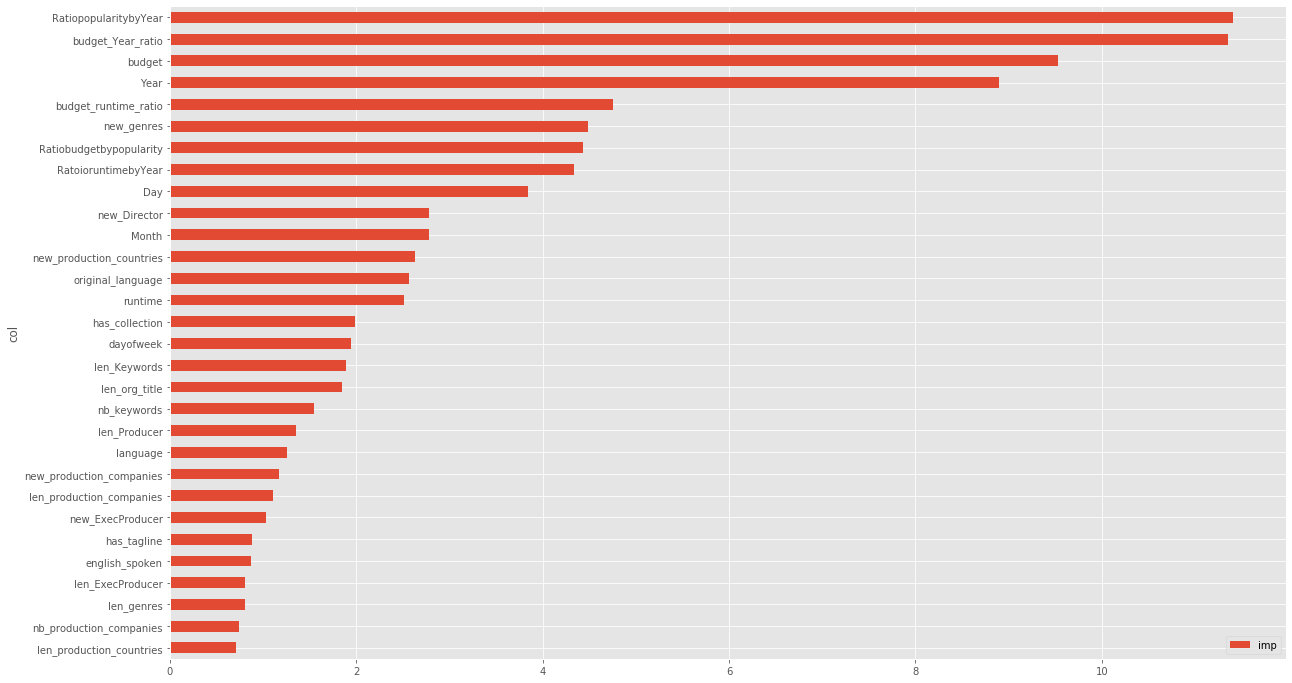

In [0]:
# Feature Importance CATB
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 12))
plt.savefig('catboost_feature_importance.png')   



In [0]:
test_features = list(set(['budget','budget','runtime','nb_spoken_languages','language','nb_production_companies',
            'Month','dayofweek','RatiopopularitybyYear','budget_runtime_ratio','has_homepage','has_tagline','isReleased','len_org_title','len_Keywords',
            'len_cast','len_Director','len_Producer','len_ExecProducer','new_production_countries','original_language','english_spoken',
            'nb_keywords','Year','Day','quarter','Ratiobudgetbypopularity','RatoioruntimebyYear','budget_Year_ratio','has_collection',
            'title_different','len_org_title','len_genres','new_genres','new_cast','new_Director','new_Producer','new_ExecProducer','len_production_countries',
            'len_production_companies','new_production_companies','new_production_countries']))

print(len(test_features))

X_test = test[test_features]
X_test.budget_runtime_ratio = X_test.budget_runtime_ratio.astype(float)
X_test.RatoioruntimebyYear = X_test.RatoioruntimebyYear.astype(float)
X_test.runtime = X_test.runtime.astype(float)


import pandas as pd
catb_pred = np.expm1(model.predict(X_test.values))
pd.DataFrame({'id': test.id, 'revenue': catb_pred}).to_csv('catbsubmission_new.csv', index=False)


39


In [0]:
X_test.shape

(4398, 39)